**6156 NMT Group Project**

Josh Fisher, Yifei Dong, Zhenrong Lao




In [1]:
#import necessary modules
import tensorflow as tf
import pandas as pd
import numpy as np
import string
import re
import itertools
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

In [3]:
# loading dataset
df_german = pd.read_csv('C:/Users/joshu/Documents/UNCC_Material/Spring_2021/Applied_Machine_Learning/Group_Project/German/news-commentary-v15.de-en.tsv', sep='\t', error_bad_lines=False, header=None, warn_bad_lines=False)
df_chinese = pd.read_csv('C:/Users/joshu/Documents/UNCC_Material/Spring_2021/Applied_Machine_Learning/Group_Project/Chinese/news-commentary-v15.en-zh.tsv', sep='\t', error_bad_lines=False, header=None, warn_bad_lines=False)

In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
#fix column names
df_german = df_german.rename(columns={0:'German', 1:'English'})
df_german.head()

,German,English
0,Steigt Gold auf 10.000 Dollar?,"$10,000 Gold?"
1,"SAN FRANCISCO – Es war noch nie leicht, ein rationales Gespräch über den Wert von Gold zu führen.",SAN FRANCISCO – It has never been easy to have a rational conversation about the value of gold.
2,"In letzter Zeit allerdings ist dies schwieriger denn je, ist doch der Goldpreis im letzten Jahrzehnt um über 300 Prozent angestiegen.","Lately, with gold prices up more than 300% over the last decade, it is harder than ever."
3,"Erst letzten Dezember verfassten meine Kollegen Martin Feldstein und Nouriel Roubini Kommentare, in denen sie mutig die vorherrschende optimistische Marktstimmung hinterfragten und sehr überlegt auf die Risiken des Goldes hinwiesen.","Just last December, fellow economists Martin Feldstein and Nouriel Roubini each penned op-eds bravely questioning bullish market sentiment, sensibly pointing out gold’s risks."
4,"Und es kam, wie es kommen musste.",Wouldn’t you know it?


In [6]:
#fix column names
df_chinese = df_chinese.rename(columns={0:'English', 1:'Chinese'})
df_chinese.head()

,English,Chinese
0,1929 or 1989?,1929年还是1989年?
1,"PARIS – As the economic crisis deepens and widens, the world has been searching for historical analogies to help us understand what has been happening.",巴黎-随着经济危机不断加深和蔓延，整个世界一直在寻找历史上的类似事件希望有助于我们了解目前正在发生的情况。
2,"At the start of the crisis, many people likened it to 1982 or 1973, which was reassuring, because both dates refer to classical cyclical downturns.",一开始，很多人把这次危机比作1982年或1973年所发生的情况，这样得类比是令人宽心的，因为这两段时期意味着典型的周期性衰退。
3,"Today, the mood is much grimmer, with references to 1929 and 1931 beginning to abound, even if some governments continue to behave as if the crisis was more classical than exceptional.",如今人们的心情却是沉重多了，许多人开始把这次危机与1929年和1931年相比，即使一些国家政府的表现仍然似乎把视目前的情况为是典型的而看见的衰退。
4,The tendency is either excessive restraint (Europe) or a diffusion of the effort (the United States).,目前的趋势是，要么是过度的克制（欧洲 ） ， 要么是努力的扩展（美国 ） 。


# **Data Preprocessing**

1. Remove missing values: self-explanatory. Removed rows where there were no text or one language text was missing

2. Convert text to lowercase: reduce redundancy and noise from the text. Prevents the model from mistaking 'Word' as different from 'word'. Also helps to reduce the size of our vocabulary

3. Remove special characters: special characters do not provide any value to understanding the text. They are not words and therefore do not require translation. Also helps to reduce size of vocabulary

4. Tokenize the documents: split documents into tokens that we will use to build our vocab and later encode into integers for training. Model understands numbers not characters, so this is the first step in encoding process. 

5. Descriptive stats: get general idea of the corpus - shape of datasets, length of text, number of unique tokens

In [7]:
#Check number of missing values
df_german.isnull().sum()

German     9453
English    9400
dtype: int64

In [8]:
#Check number of missing values
df_chinese.isnull().sum()

English    8224
Chinese    8168
dtype: int64

In [9]:
#Check id of missing values
df_german[df_german.isnull().any(axis=1)]

,German,English
46,NaN,NaN
77,NaN,NaN
117,Der Neoliberalismus füllte dieses Vakuum.,NaN
127,NaN,NaN
167,NaN,NaN
...,...,...
369595,NaN,NaN
369627,NaN,NaN
369658,NaN,NaN
369696,NaN,NaN


In [10]:
#Check id of missing values
df_chinese[df_chinese.isnull().any(axis=1)]

,English,Chinese
30,NaN,NaN
65,NaN,NaN
97,NaN,NaN
136,NaN,NaN
172,NaN,NaN
...,...,...
320604,NaN,NaN
320637,NaN,NaN
320676,NaN,NaN
320682,Zuma is legendary for his ability to connect with ordinary people.,NaN


In [11]:
#remove missing values
df_german = df_german.dropna()
df_german.isnull().sum()

German     0
English    0
dtype: int64

In [12]:
#remove missing values
df_chinese = df_chinese.dropna()
df_chinese.isnull().sum()

English    0
Chinese    0
dtype: int64

In [13]:
#convert everything to lower case to get rid of unhelpful parts of the data and reduce noise. Also preventing the model from idenyify capitalized words as different words. 
df_german['German'] = df_german['German'].apply(lambda x:x.lower())
df_german['English'] = df_german['English'].apply(lambda x:x.lower())

df_chinese['Chinese'] = df_chinese['Chinese'].apply(lambda x:x.lower())
df_chinese['English'] = df_chinese['English'].apply(lambda x:x.lower())

In [14]:
df_chinese.head()

,English,Chinese
0,1929 or 1989?,1929年还是1989年?
1,"paris – as the economic crisis deepens and widens, the world has been searching for historical analogies to help us understand what has been happening.",巴黎-随着经济危机不断加深和蔓延，整个世界一直在寻找历史上的类似事件希望有助于我们了解目前正在发生的情况。
2,"at the start of the crisis, many people likened it to 1982 or 1973, which was reassuring, because both dates refer to classical cyclical downturns.",一开始，很多人把这次危机比作1982年或1973年所发生的情况，这样得类比是令人宽心的，因为这两段时期意味着典型的周期性衰退。
3,"today, the mood is much grimmer, with references to 1929 and 1931 beginning to abound, even if some governments continue to behave as if the crisis was more classical than exceptional.",如今人们的心情却是沉重多了，许多人开始把这次危机与1929年和1931年相比，即使一些国家政府的表现仍然似乎把视目前的情况为是典型的而看见的衰退。
4,the tendency is either excessive restraint (europe) or a diffusion of the effort (the united states).,目前的趋势是，要么是过度的克制（欧洲 ） ， 要么是努力的扩展（美国 ） 。


In [15]:
#remove special characters, because all the special characters for both languages are the same, removing it can help reduce noise. 
df_german['German'] = df_german['German'].map(lambda x: re.sub(r"[$%-()\"#/@;:<>{}`+=~|.!?,]", "", x))
df_german['English'] = df_german['English'].map(lambda x: re.sub(r"[$%-()\"#/@;:<>{}`+=~|.!?,]", "", x))

df_german.head()

,German,English
0,steigt gold auf 10000 dollar,10000 gold
1,san francisco – es war noch nie leicht ein rationales gespräch über den wert von gold zu führen,san francisco – it has never been easy to have a rational conversation about the value of gold
2,in letzter zeit allerdings ist dies schwieriger denn je ist doch der goldpreis im letzten jahrzehnt um über 300 prozent angestiegen,lately with gold prices up more than 300 over the last decade it is harder than ever
3,erst letzten dezember verfassten meine kollegen martin feldstein und nouriel roubini kommentare in denen sie mutig die vorherrschende optimistische marktstimmung hinterfragten und sehr überlegt auf die risiken des goldes hinwiesen,just last december fellow economists martin feldstein and nouriel roubini each penned op-eds bravely questioning bullish market sentiment sensibly pointing out gold’s risks
4,und es kam wie es kommen musste,wouldn’t you know it


In [16]:
# remove some special regular expression, because all the expression characters for both languages are the same,removing it can help reduce noise. 
df_chinese['Chinese'] = df_chinese['Chinese'].map(lambda x: re.sub(r"[$%-()\"#/@;:<>{}`+=~|.!?,]", "", x))
df_chinese['English'] = df_chinese['English'].map(lambda x: re.sub(r"[$%-()\"#/@;:<>{}`+=~|.!?,]", "", x))

df_chinese.head()

,English,Chinese
0,1929 or 1989,1929年还是1989年
1,paris – as the economic crisis deepens and widens the world has been searching for historical analogies to help us understand what has been happening,巴黎-随着经济危机不断加深和蔓延，整个世界一直在寻找历史上的类似事件希望有助于我们了解目前正在发生的情况。
2,at the start of the crisis many people likened it to 1982 or 1973 which was reassuring because both dates refer to classical cyclical downturns,一开始，很多人把这次危机比作1982年或1973年所发生的情况，这样得类比是令人宽心的，因为这两段时期意味着典型的周期性衰退。
3,today the mood is much grimmer with references to 1929 and 1931 beginning to abound even if some governments continue to behave as if the crisis was more classical than exceptional,如今人们的心情却是沉重多了，许多人开始把这次危机与1929年和1931年相比，即使一些国家政府的表现仍然似乎把视目前的情况为是典型的而看见的衰退。
4,the tendency is either excessive restraint europe or a diffusion of the effort the united states,目前的趋势是，要么是过度的克制（欧洲 ） ， 要么是努力的扩展（美国 ） 。


In [17]:
# Tokenize documents in german-english pair dataset
german_tokenizer = RegexpTokenizer(r'\w+')
df_german['tokenized_german'] = df_german['German'].apply(german_tokenizer.tokenize)
df_german['tokenized_english'] = df_german['English'].apply(german_tokenizer.tokenize)

In [18]:
df_german.head()

,German,English,tokenized_german,tokenized_english
0,steigt gold auf 10000 dollar,10000 gold,"[steigt, gold, auf, 10000, dollar]","[10000, gold]"
1,san francisco – es war noch nie leicht ein rationales gespräch über den wert von gold zu führen,san francisco – it has never been easy to have a rational conversation about the value of gold,"[san, francisco, es, war, noch, nie, leicht, ein, rationales, gespräch, über, den, wert, von, gold, zu, führen]","[san, francisco, it, has, never, been, easy, to, have, a, rational, conversation, about, the, value, of, gold]"
2,in letzter zeit allerdings ist dies schwieriger denn je ist doch der goldpreis im letzten jahrzehnt um über 300 prozent angestiegen,lately with gold prices up more than 300 over the last decade it is harder than ever,"[in, letzter, zeit, allerdings, ist, dies, schwieriger, denn, je, ist, doch, der, goldpreis, im, letzten, jahrzehnt, um, über, 300, prozent, angestiegen]","[lately, with, gold, prices, up, more, than, 300, over, the, last, decade, it, is, harder, than, ever]"
3,erst letzten dezember verfassten meine kollegen martin feldstein und nouriel roubini kommentare in denen sie mutig die vorherrschende optimistische marktstimmung hinterfragten und sehr überlegt auf die risiken des goldes hinwiesen,just last december fellow economists martin feldstein and nouriel roubini each penned op-eds bravely questioning bullish market sentiment sensibly pointing out gold’s risks,"[erst, letzten, dezember, verfassten, meine, kollegen, martin, feldstein, und, nouriel, roubini, kommentare, in, denen, sie, mutig, die, vorherrschende, optimistische, marktstimmung, hinterfragten, und, sehr, überlegt, auf, die, risiken, des, goldes, hinwiesen]","[just, last, december, fellow, economists, martin, feldstein, and, nouriel, roubini, each, penned, op, eds, bravely, questioning, bullish, market, sentiment, sensibly, pointing, out, gold, s, risks]"
4,und es kam wie es kommen musste,wouldn’t you know it,"[und, es, kam, wie, es, kommen, musste]","[wouldn, t, you, know, it]"


In [19]:
#chinese characters aren't separated by spaces so need to do additional regexp
chinese_tokenizer = RegexpTokenizer(u'[\u2E00-\u9fff]|[0-9]+|[a-zA-Z]+|[%s]'% re.escape(string.punctuation))

df_chinese['tokenized_english'] = df_chinese['English'].apply(chinese_tokenizer.tokenize)
df_chinese['tokenized_chinese'] = df_chinese['Chinese'].apply(chinese_tokenizer.tokenize)

In [20]:
df_chinese.head()

,English,Chinese,tokenized_english,tokenized_chinese
0,1929 or 1989,1929年还是1989年,"[1929, or, 1989]","[1929, 年, 还, 是, 1989, 年]"
1,paris – as the economic crisis deepens and widens the world has been searching for historical analogies to help us understand what has been happening,巴黎-随着经济危机不断加深和蔓延，整个世界一直在寻找历史上的类似事件希望有助于我们了解目前正在发生的情况。,"[paris, as, the, economic, crisis, deepens, and, widens, the, world, has, been, searching, for, historical, analogies, to, help, us, understand, what, has, been, happening]","[巴, 黎, -, 随, 着, 经, 济, 危, 机, 不, 断, 加, 深, 和, 蔓, 延, 整, 个, 世, 界, 一, 直, 在, 寻, 找, 历, 史, 上, 的, 类, 似, 事, 件, 希, 望, 有, 助, 于, 我, 们, 了, 解, 目, 前, 正, 在, 发, 生, 的, 情, 况, 。]"
2,at the start of the crisis many people likened it to 1982 or 1973 which was reassuring because both dates refer to classical cyclical downturns,一开始，很多人把这次危机比作1982年或1973年所发生的情况，这样得类比是令人宽心的，因为这两段时期意味着典型的周期性衰退。,"[at, the, start, of, the, crisis, many, people, likened, it, to, 1982, or, 1973, which, was, reassuring, because, both, dates, refer, to, classical, cyclical, downturns]","[一, 开, 始, 很, 多, 人, 把, 这, 次, 危, 机, 比, 作, 1982, 年, 或, 1973, 年, 所, 发, 生, 的, 情, 况, 这, 样, 得, 类, 比, 是, 令, 人, 宽, 心, 的, 因, 为, 这, 两, 段, 时, 期, 意, 味, 着, 典, 型, 的, 周, 期, 性, 衰, 退, 。]"
3,today the mood is much grimmer with references to 1929 and 1931 beginning to abound even if some governments continue to behave as if the crisis was more classical than exceptional,如今人们的心情却是沉重多了，许多人开始把这次危机与1929年和1931年相比，即使一些国家政府的表现仍然似乎把视目前的情况为是典型的而看见的衰退。,"[today, the, mood, is, much, grimmer, with, references, to, 1929, and, 1931, beginning, to, abound, even, if, some, governments, continue, to, behave, as, if, the, crisis, was, more, classical, than, exceptional]","[如, 今, 人, 们, 的, 心, 情, 却, 是, 沉, 重, 多, 了, 许, 多, 人, 开, 始, 把, 这, 次, 危, 机, 与, 1929, 年, 和, 1931, 年, 相, 比, 即, 使, 一, 些, 国, 家, 政, 府, 的, 表, 现, 仍, 然, 似, 乎, 把, 视, 目, 前, 的, 情, 况, 为, 是, 典, 型, 的, 而, 看, 见, 的, 衰, 退, 。]"
4,the tendency is either excessive restraint europe or a diffusion of the effort the united states,目前的趋势是，要么是过度的克制（欧洲 ） ， 要么是努力的扩展（美国 ） 。,"[the, tendency, is, either, excessive, restraint, europe, or, a, diffusion, of, the, effort, the, united, states]","[目, 前, 的, 趋, 势, 是, 要, 么, 是, 过, 度, 的, 克, 制, 欧, 洲, 要, 么, 是, 努, 力, 的, 扩, 展, 美, 国, 。]"


In [21]:
#Check one observation
df_chinese.iloc[4]

English                               the tendency is either excessive restraint europe or a diffusion of the effort the united states
Chinese                                                                                         目前的趋势是，要么是过度的克制（欧洲 ） ， 要么是努力的扩展（美国 ） 。
tokenized_english    [the, tendency, is, either, excessive, restraint, europe, or, a, diffusion, of, the, effort, the, united, states]
tokenized_chinese                                    [目, 前, 的, 趋, 势, 是, 要, 么, 是, 过, 度, 的, 克, 制, 欧, 洲, 要, 么, 是, 努, 力, 的, 扩, 展, 美, 国, 。]
Name: 4, dtype: object

In [22]:
# Check sentence length 
df_german['num_german_tokens'] = df_german['tokenized_german'].apply(len)
df_german['num_english_tokens'] = df_german['tokenized_english'].apply(len)

df_chinese['num_english_tokens'] = df_chinese['tokenized_english'].apply(len)
df_chinese['num_chinese_tokens'] = df_chinese['tokenized_chinese'].apply(len)

In [23]:
df_german.head()

,German,English,tokenized_german,tokenized_english,num_german_tokens,num_english_tokens
0,steigt gold auf 10000 dollar,10000 gold,"[steigt, gold, auf, 10000, dollar]","[10000, gold]",5,2
1,san francisco – es war noch nie leicht ein rationales gespräch über den wert von gold zu führen,san francisco – it has never been easy to have a rational conversation about the value of gold,"[san, francisco, es, war, noch, nie, leicht, ein, rationales, gespräch, über, den, wert, von, gold, zu, führen]","[san, francisco, it, has, never, been, easy, to, have, a, rational, conversation, about, the, value, of, gold]",17,17
2,in letzter zeit allerdings ist dies schwieriger denn je ist doch der goldpreis im letzten jahrzehnt um über 300 prozent angestiegen,lately with gold prices up more than 300 over the last decade it is harder than ever,"[in, letzter, zeit, allerdings, ist, dies, schwieriger, denn, je, ist, doch, der, goldpreis, im, letzten, jahrzehnt, um, über, 300, prozent, angestiegen]","[lately, with, gold, prices, up, more, than, 300, over, the, last, decade, it, is, harder, than, ever]",21,17
3,erst letzten dezember verfassten meine kollegen martin feldstein und nouriel roubini kommentare in denen sie mutig die vorherrschende optimistische marktstimmung hinterfragten und sehr überlegt auf die risiken des goldes hinwiesen,just last december fellow economists martin feldstein and nouriel roubini each penned op-eds bravely questioning bullish market sentiment sensibly pointing out gold’s risks,"[erst, letzten, dezember, verfassten, meine, kollegen, martin, feldstein, und, nouriel, roubini, kommentare, in, denen, sie, mutig, die, vorherrschende, optimistische, marktstimmung, hinterfragten, und, sehr, überlegt, auf, die, risiken, des, goldes, hinwiesen]","[just, last, december, fellow, economists, martin, feldstein, and, nouriel, roubini, each, penned, op, eds, bravely, questioning, bullish, market, sentiment, sensibly, pointing, out, gold, s, risks]",30,25
4,und es kam wie es kommen musste,wouldn’t you know it,"[und, es, kam, wie, es, kommen, musste]","[wouldn, t, you, know, it]",7,5


In [24]:
df_chinese.head()

,English,Chinese,tokenized_english,tokenized_chinese,num_english_tokens,num_chinese_tokens
0,1929 or 1989,1929年还是1989年,"[1929, or, 1989]","[1929, 年, 还, 是, 1989, 年]",3,6
1,paris – as the economic crisis deepens and widens the world has been searching for historical analogies to help us understand what has been happening,巴黎-随着经济危机不断加深和蔓延，整个世界一直在寻找历史上的类似事件希望有助于我们了解目前正在发生的情况。,"[paris, as, the, economic, crisis, deepens, and, widens, the, world, has, been, searching, for, historical, analogies, to, help, us, understand, what, has, been, happening]","[巴, 黎, -, 随, 着, 经, 济, 危, 机, 不, 断, 加, 深, 和, 蔓, 延, 整, 个, 世, 界, 一, 直, 在, 寻, 找, 历, 史, 上, 的, 类, 似, 事, 件, 希, 望, 有, 助, 于, 我, 们, 了, 解, 目, 前, 正, 在, 发, 生, 的, 情, 况, 。]",24,52
2,at the start of the crisis many people likened it to 1982 or 1973 which was reassuring because both dates refer to classical cyclical downturns,一开始，很多人把这次危机比作1982年或1973年所发生的情况，这样得类比是令人宽心的，因为这两段时期意味着典型的周期性衰退。,"[at, the, start, of, the, crisis, many, people, likened, it, to, 1982, or, 1973, which, was, reassuring, because, both, dates, refer, to, classical, cyclical, downturns]","[一, 开, 始, 很, 多, 人, 把, 这, 次, 危, 机, 比, 作, 1982, 年, 或, 1973, 年, 所, 发, 生, 的, 情, 况, 这, 样, 得, 类, 比, 是, 令, 人, 宽, 心, 的, 因, 为, 这, 两, 段, 时, 期, 意, 味, 着, 典, 型, 的, 周, 期, 性, 衰, 退, 。]",25,54
3,today the mood is much grimmer with references to 1929 and 1931 beginning to abound even if some governments continue to behave as if the crisis was more classical than exceptional,如今人们的心情却是沉重多了，许多人开始把这次危机与1929年和1931年相比，即使一些国家政府的表现仍然似乎把视目前的情况为是典型的而看见的衰退。,"[today, the, mood, is, much, grimmer, with, references, to, 1929, and, 1931, beginning, to, abound, even, if, some, governments, continue, to, behave, as, if, the, crisis, was, more, classical, than, exceptional]","[如, 今, 人, 们, 的, 心, 情, 却, 是, 沉, 重, 多, 了, 许, 多, 人, 开, 始, 把, 这, 次, 危, 机, 与, 1929, 年, 和, 1931, 年, 相, 比, 即, 使, 一, 些, 国, 家, 政, 府, 的, 表, 现, 仍, 然, 似, 乎, 把, 视, 目, 前, 的, 情, 况, 为, 是, 典, 型, 的, 而, 看, 见, 的, 衰, 退, 。]",31,65
4,the tendency is either excessive restraint europe or a diffusion of the effort the united states,目前的趋势是，要么是过度的克制（欧洲 ） ， 要么是努力的扩展（美国 ） 。,"[the, tendency, is, either, excessive, restraint, europe, or, a, diffusion, of, the, effort, the, united, states]","[目, 前, 的, 趋, 势, 是, 要, 么, 是, 过, 度, 的, 克, 制, 欧, 洲, 要, 么, 是, 努, 力, 的, 扩, 展, 美, 国, 。]",16,27


In [25]:
# Summary statistics of two datasets
print('Number of paired german-english sentences: ', df_german.shape[0])
print('Average german sentence length: ', df_german['num_german_tokens'].mean())
print('Average english sentence length: ', df_german['num_english_tokens'].mean())
print('')
print('Number of paired chinese-english sentences: ', df_chinese.shape[0])
print('Average chinese sentence length: ', df_chinese['num_chinese_tokens'].mean())
print('Average english sentence length: ', df_chinese['num_english_tokens'].mean())

Number of paired german-english sentences:  359987
Average german sentence length:  22.498656895943466
Average english sentence length:  22.309563956476207

Number of paired chinese-english sentences:  312268
Average chinese sentence length:  38.50334007967515
Average english sentence length:  22.76418332970397


Interesting to see that the chinese sentences are on average much longer than the paired english sentences. 

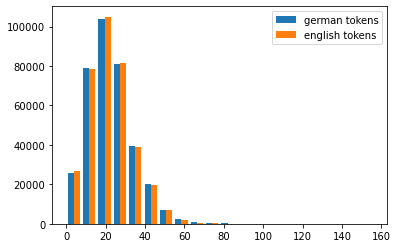

In [26]:
# histgram of number of tokens
plt.hist([df_german['num_german_tokens'],df_german['num_english_tokens']],bins=20, label=['german tokens', 'english tokens'])
plt.legend(loc='upper right')

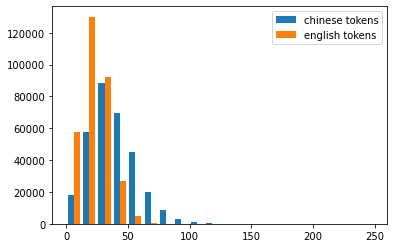

In [27]:
# histgram of number of tokens
plt.hist([df_chinese['num_chinese_tokens'],df_chinese['num_english_tokens']],bins=20, label=['chinese tokens', 'english tokens'])
plt.legend(loc='upper right')

In [28]:
#Number of unique tokens
german_vocab = len(set(itertools.chain.from_iterable(df_german.tokenized_german)))
english_german_vocab = len(set(itertools.chain.from_iterable(df_german.tokenized_english)))

print('Number of unique german words:', german_vocab)
print('Number of unique english words: ', english_german_vocab)

Number of unique german words: 183694
Number of unique english words:  62597


In [29]:
#Number of unique tokens
chinese_vocab = len(set(itertools.chain.from_iterable(df_chinese.tokenized_chinese)))
english_chinese_vocab = len(set(itertools.chain.from_iterable(df_chinese.tokenized_english)))

print('Number of unique chinese words:', chinese_vocab)
print('Number of unique english words: ', english_chinese_vocab)

Number of unique chinese words: 20883
Number of unique english words:  57498


In the german dataset there are 3x as many words used to say the same thing as in english

In the chinese dataset there are very few unique tokens used compared to english

# **Data Preparation for Modeling**

1. Limit sentence length to 15 words to curtail vanishing gradients and overfitting.

2. Partition data into train and test

*   For final model we used 90,000 samples for the training set and 100 for the test set in each language   

*   The chinese data set had trouble converting from text to sequence using the original cleaned data so we used the tokenized version from the EDA and joined using a space

3. Tokenize and fit the tokenizer to the text using tensorflows fit_on_texts

*   Limit number of words to 10,000

*   Fitting the tokenizer to the corpus creates the vocabulary dictionary and allows us to calculate size of vocab that we will use as an input into the model. We can then use this index:word vocab to reverse translate from sequence to word when translating

4. Convert strings to integer values using tf.texts_to_sequences

*   Computers understand numbers not strings. Use the previously created vocabulary to map each token to an integer


5. Pad data to fixed length to match longest sequence for each language sets


*   Final step in the pre-processing steps. Each of the sequences are padded with zeroes to a fixed length. We defined this fixed length as the length of the longest sentence in each set. Padding is neccessary to allow the encoder to encode the data in batches. Batches need to all be in a uniform length


 

In [30]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, LSTM, TimeDistributed, RepeatVector, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer as tf_Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [31]:
#limit max length of the sentence pairs to 15 tokens
df_german = df_german[df_german['tokenized_german'].apply(lambda x: len(x) < 16)]
df_german = df_german[df_german['tokenized_english'].apply(lambda x: len(x) < 16)]

df_chinese = df_chinese[df_chinese['tokenized_chinese'].apply(lambda x: len(x) < 16)]
df_chinese = df_chinese[df_chinese['tokenized_english'].apply(lambda x: len(x) < 16)]

In [32]:
#divide into train and test sets. For the final model we're using the first 90,000 samples to train and the last 100 to test in each language set
german_train_df = df_german.iloc[:90000]
german_train = german_train_df['German'].tolist()
german_english_train = german_train_df['English'].tolist()

german_test_df = df_german.iloc[-100:]
german_test = german_test_df['German'].tolist()
german_english_test = german_test_df['English'].tolist()


chinese_train_df = df_chinese.iloc[:90000]
#fitting the chinese text to sequences did not work properly since there are no spaces between the chinese characters. 
#So, I first use the tokenized_chinese sequences that we used in the EDA above and join them with a space
tokenized_train_chinese = chinese_train_df['tokenized_chinese'].tolist()
chinese_train = []
for sent in tokenized_train_chinese:
  text = ' '.join(sent)
  chinese_train.append(text)



chinese_english_train = chinese_train_df['English'].tolist()

chinese_test_df = df_chinese.iloc[-100:]
#same as above
tokenized_test_chinese = chinese_test_df['tokenized_chinese'].tolist()
chinese_test = []
for sent in tokenized_test_chinese:
  text = ' '.join(sent)
  chinese_test.append(text)

chinese_english_test = chinese_test_df['English'].tolist()

In [33]:
#sample training example
german_train[0]

'steigt gold auf 10000 dollar'

In [34]:
#tokenize training set. limit vocab to 10,000 words to prevent overfitting and decrease training time
german_tokenizer = tf_Tokenizer(num_words=10000)
german_tokenizer.fit_on_texts(german_train)

german_english_tokenzier = tf_Tokenizer(num_words=10000)
german_english_tokenzier.fit_on_texts(german_english_train)

chinese_tokenizer = tf_Tokenizer(num_words=10000)
chinese_tokenizer.fit_on_texts(chinese_train)

chinese_english_tokenzier = tf_Tokenizer(num_words=10000)
chinese_english_tokenzier.fit_on_texts(chinese_english_train)

In [35]:
#save each vocabulary sets and vocab sizes for model
german_vocab = german_tokenizer.word_index
german_vocab_size = len(german_vocab) + 1

german_english_vocab = german_english_tokenzier.word_index
german_english_vocab_size = len(german_english_vocab) + 1

chinese_vocab = chinese_tokenizer.word_index
chinese_vocab_size = len(chinese_vocab) + 1

chinese_english_vocab = chinese_english_tokenzier.word_index
chinese_english_vocab_size = len(chinese_english_vocab) + 1

In [36]:
#encode the sentences into integers
german_encoder_sequences = german_tokenizer.texts_to_sequences(german_train)
german_english_sequences = german_english_tokenzier.texts_to_sequences(german_english_train)

chinese_encoder_sequences = chinese_tokenizer.texts_to_sequences(chinese_train)
chinese_english_sequences = chinese_english_tokenzier.texts_to_sequences(chinese_english_train)

In [37]:
print(german_train[10])
print(german_encoder_sequences[10])
print('')
print(german_english_train[10])
print(german_english_sequences[10])

daher ist es gefährlich aus kurzfristigen trends prognosen abzuleiten
[168, 4, 9, 777, 40, 2987, 1103, 1714]

it is therefore dangerous to extrapolate from short-term trends
[15, 2, 661, 459, 4, 32, 228, 188, 1058]


In [38]:
#pad sequences with zeros the fix each vector at the max sentence length
german_encoder_sequences_padded = pad_sequences(german_encoder_sequences, padding='post')
german_english_sequences_padded = pad_sequences(german_english_sequences, padding='post')

chinese_encoder_sequences_padded = pad_sequences(chinese_encoder_sequences, padding='post')
chinese_english_sequences_padded = pad_sequences(chinese_english_sequences, padding='post')

In [39]:
#reshape the target sequences
german_english_sequences_padded = german_english_sequences_padded.reshape(german_english_sequences_padded.shape[0], german_english_sequences_padded.shape[1],1)
chinese_english_sequences_padded = chinese_english_sequences_padded.reshape(chinese_english_sequences_padded.shape[0], chinese_english_sequences_padded.shape[1],1)

In [40]:
print('Encoder sample:', german_encoder_sequences_padded[10])
print('English encoder sample: ', german_english_sequences_padded[10])

Encoder sample: [ 168    4    9  777   40 2987 1103 1714    0    0    0    0    0    0
    0    0    0]
English encoder sample:  [[  15]
 [   2]
 [ 661]
 [ 459]
 [   4]
 [  32]
 [ 228]
 [ 188]
 [1058]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]]


In [41]:
print('Length of german encoder sample: ', len(german_encoder_sequences_padded[10]))
print('Length of german-english input sample: ', len(german_english_sequences_padded[10]))
print('')
print('Length of chinese encoder sample: ', len(chinese_encoder_sequences_padded[10]))
print('Length of chinese-english input sample: ', len(chinese_english_sequences_padded[10]))

Length of german encoder sample:  17
Length of german-english input sample:  18

Length of chinese encoder sample:  15
Length of chinese-english input sample:  17


In [42]:
#save vector length for model input
german_encoder_size = len(german_encoder_sequences_padded[0])
german_english_size = len(german_english_sequences_padded[0])

chinese_encoder_size = len(chinese_encoder_sequences_padded[0])
chinese_english_size = len(chinese_english_sequences_padded[0])

<h1> LSTM Model Architecture <h1>

From our literature research we believe that the LSTM model is a good fit for this type of project. The LSTM model is an upgrade to the simple recurrent neural network that is best suited to remember information over the span of a sequence. The LSTM model has a cell state that is responsible for keeping track of all the important information. This information is control by three gates: Input, Output, and Forget gate which all work to determine the state of the information and decide what is and isn't important. 

We learned of this information from a published paper entitled, "Sequence to Sequence Learning with Neural Networks." (https://papers.nips.cc/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf) This paper helped us formulate a plan on how to build the model and the appropriate stesp to take to get it working. 

This model follows a simple LSTM encoder-decoder architecture which resembles this tutorial (https://youtu.be/7gHqxK1o7MU).

* Layer 1 - Embedding - converts each word integer into an embedding vector
* Layer 2 - LSTM - Encoding layer - 64 hidden units that encode the sentences
* Layer 3 - RepeatVector - repeats the output of the LSTM layer to maintain dimensions
* Layer 4 - LSTM - decoding payer - 64 hidden units that decode the sentences, has return_sequences = True which allows the decoder to understand the hidden state output at each timestep
* Layer 5 - Dense - Classifies the decoded words


<h1> German LSTM Model Training

Hyperparameters


*   Optimizer - Adam with learning rate = 0.001
*   Loss function - sparse_categorical_crossentropy (sparse because it allows us to use the original structure of the sequences. If I were to one-hot encode and use cateogrical_crossentropy my RAM would explode)
*   Metric - Accuracy
*   Epochs - 100
*   Batch size = 64
*   Validation split = 0.2
*   Dropout = 0.5









In [43]:
#define model architecture
german_model = Sequential()
german_model.add(Embedding(10000, 64, input_length=german_encoder_size, mask_zero=True))
german_model.add(LSTM(64, dropout=0.5))
german_model.add(RepeatVector(german_english_size))
german_model.add(LSTM(64, return_sequences=True))
german_model.add(Dense(10000, activation='softmax'))

In [44]:
german_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 17, 64)            640000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 18, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 18, 64)            33024     
_________________________________________________________________
dense (Dense)                (None, 18, 10000)         650000    
Total params: 1,356,048
Trainable params: 1,356,048
Non-trainable params: 0
_________________________________________________________________


In [45]:
#define optimizer, loss function, and metric
adam = Adam(lr=0.001)
german_model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [51]:
#train model
history = german_model.fit(german_encoder_sequences_padded, german_english_sequences_padded, epochs=150, batch_size=64, validation_split=0.2)

Epoch 1/150
1125/1125 [==============================] - 58s 35ms/step - loss: 4.8831 - accuracy: 0.4828 - val_loss: 3.7516 - val_accuracy: 0.5066
Epoch 2/150
1125/1125 [==============================] - 38s 34ms/step - loss: 3.7281 - accuracy: 0.5073 - val_loss: 3.6994 - val_accuracy: 0.5105
Epoch 3/150
1125/1125 [==============================] - 38s 34ms/step - loss: 3.6784 - accuracy: 0.5098 - val_loss: 3.6903 - val_accuracy: 0.5106
Epoch 4/150
1125/1125 [==============================] - 38s 34ms/step - loss: 3.6594 - accuracy: 0.5100 - val_loss: 3.6755 - val_accuracy: 0.5107
Epoch 5/150
1125/1125 [==============================] - 38s 34ms/step - loss: 3.6444 - accuracy: 0.5107 - val_loss: 3.6701 - val_accuracy: 0.5111
Epoch 6/150
1125/1125 [==============================] - 38s 34ms/step - loss: 3.6217 - accuracy: 0.5120 - val_loss: 3.6632 - val_accuracy: 0.5137
Epoch 7/150
1125/1125 [==============================] - 38s 34ms/step - loss: 3.6004 - accuracy: 0.5157 - val_loss: 3

In [52]:
# german_model.save('/german_LSTM_model.h5')

In [ ]:
# german_model.load_weights('/german_LSTM_model.h5')

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

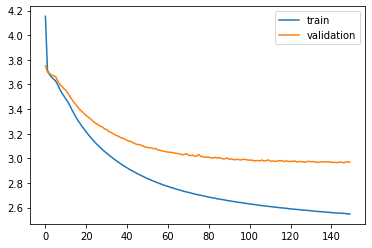

In [53]:
#plot losses by epoch
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()

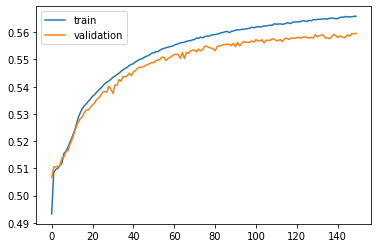

In [54]:
#plot accuracy by epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation'])
plt.show()

<h3> German LSTM Model Training Observations <h3>

*   Both the training and validation loss decrease throughout training.  
*   The training and validation accuracy continue to increase, plateauing at around 0.55

<h1> German LSTM Model Evaluation <h1>

To evaluate the performance of the models we chose to use the metrics BLEU and F-score


*   The BLEU metric (https://machinelearningmastery.com/calculate-bleu-score-for-text-python/) is a score that is used to compare the translation of text. It is a very common metric used in the field of NMT. The BLEU score evaluates a sentence and returns a value from range 0 (mismatch) to 1 (match). This metric works by counting the matching n-grams in the actual and prediction sentences. The higher number of matches the higher the score. For our model, we will use NLTK's sentence_bleu function to measure the similarity between each predicted phrases in the test set. Specifically, we used BLEU-1 which counts the number of individual 1-grams that match. We feel that this is a good approach as this is a commonly used technique and is best suited for comparing actual and translated sentences 
*   The second metric that we chose to evaluate our predictions is NLTK's character n-gram F-score metric (https://www.aclweb.org/anthology/W15-3049.pdf). We chose this metric because we wanted to chose something that worked differently but similar to the BLEU metric. This metric looks at the individual characters in both the reference and hypothesis sentence and predicts the F-score. The F-score is a combined measure of precision and recall. A higher F-score indicates how well the model accurately classifies each other phrases on a character by character basis



In [55]:
#encode and pad test sequences
german_test_seq = german_tokenizer.texts_to_sequences(german_test)

german_test_seq_pad = pad_sequences(german_test_seq, padding='post', maxlen=17)

In [64]:
#function to convert to predict logit to word
def logits_to_sentence(logits, tokenizer):

    index_to_words = {idx: word for word, idx in tokenizer.items()}
    index_to_words[0] = '' 

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [65]:
#loop to iterate through test sequences and append the predicted vs actual sequence
german_predicted, german_actual = [], []

index = 0
while index < len(german_test_seq_pad):
  result = logits_to_sentence(german_model.predict(german_test_seq_pad[index:index+1])[0], german_english_vocab)
  german_predicted.append(result)
  german_actual.append(german_english_test[index])
  index += 1

In [59]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.chrf_score import sentence_chrf

In [66]:
#define empty result dataframe
german_result_df = pd.DataFrame(columns=['actual', 'prediction', 'bleu_score', 'F_score'])

In [ ]:
#loop to iterate through predicted and actual phrases and evaluate performance using bleu and f-score
for i in range(len(german_predicted)):
  bleu_comparison = sentence_bleu(german_actual[i], german_predicted[i], weights=(1, 0, 0, 0))
  chrF_comparison = sentence_chrf(german_actual[i], german_predicted[i], max_len=1)
  temp_df = pd.DataFrame({'actual':german_actual[i], 'prediction':german_predicted[i], 'bleu_score':bleu_comparison, 'F_score':chrF_comparison}, index=[0])
  german_result_df = german_result_df.append(temp_df)

In [69]:
german_result_df

,actual,prediction,bleu_score,F_score
0,a bill to curb sexual and gender-based violence is also in the pipeline,a sexual of a sexual sexual sexual and and and,0.185185,0.562771
0,but our work is far from finished,but our is is not,0.300000,0.550459
0,nevertheless the future looks bright,but even the future future,0.256410,0.606061
0,among the acu’s key areas of work is gender equity,the is the is is,0.206897,0.396660
0,a zero-carbon economy is within reach,a economy is is,0.344828,0.441989
...,...,...,...,...
0,until now populism has been the missing note in african political culture,so far result has has has political political political political,0.191781,0.739726
0,dismissing complaints zuma insists “there’s no cloud around me”,they this that to to and and,0.256410,0.396040
0,the stakes for africa are enormous,in africa is is,0.275862,0.417910
0,zuma senses the urgency of the situation,is the the the the,0.193548,0.460358


In [70]:
print('Mean BLEU-1 score: ', german_result_df['bleu_score'].mean())
print('Mean character F-score: ', german_result_df['F_score'].mean())

Mean BLEU-1 score:  0.24055043205363003
Mean character F-score:  0.4803209465572884


<h1> Chinese LSTM Model Training <h1>

Same model as the german model that was trained above. 

In [71]:
#define model architecture
chinese_model = Sequential()
chinese_model.add(Embedding(10000, 64, input_length=chinese_encoder_size, mask_zero=True))
chinese_model.add(LSTM(64, dropout=0.5))
chinese_model.add(RepeatVector(chinese_english_size))
chinese_model.add(LSTM(64, return_sequences=True))
chinese_model.add(TimeDistributed(Dense(10000, activation='softmax')))

In [72]:
chinese_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 64)            640000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 17, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 17, 64)            33024     
_________________________________________________________________
time_distributed (TimeDistri (None, 17, 10000)         650000    
Total params: 1,356,048
Trainable params: 1,356,048
Non-trainable params: 0
_________________________________________________________________


In [73]:
#define optimizer, loss function, and metric
adam = Adam(lr=0.001)
chinese_model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [75]:
#train model
chinese_history = chinese_model.fit(chinese_encoder_sequences_padded, chinese_english_sequences_padded, epochs=150, batch_size=64, validation_split=0.2)

Epoch 1/150
351/351 [==============================] - 19s 40ms/step - loss: 5.1505 - accuracy: 0.6218 - val_loss: 2.7330 - val_accuracy: 0.6413
Epoch 2/150
351/351 [==============================] - 13s 36ms/step - loss: 2.7357 - accuracy: 0.6392 - val_loss: 2.6148 - val_accuracy: 0.6552
Epoch 3/150
351/351 [==============================] - 13s 36ms/step - loss: 2.6462 - accuracy: 0.6510 - val_loss: 2.5791 - val_accuracy: 0.6587
Epoch 4/150
351/351 [==============================] - 13s 36ms/step - loss: 2.6167 - accuracy: 0.6516 - val_loss: 2.5655 - val_accuracy: 0.6604
Epoch 5/150
351/351 [==============================] - 13s 36ms/step - loss: 2.5893 - accuracy: 0.6546 - val_loss: 2.5558 - val_accuracy: 0.6617
Epoch 6/150
351/351 [==============================] - 13s 36ms/step - loss: 2.5628 - accuracy: 0.6571 - val_loss: 2.5524 - val_accuracy: 0.6618
Epoch 7/150
351/351 [==============================] - 12s 36ms/step - loss: 2.5596 - accuracy: 0.6576 - val_loss: 2.5505 - val_ac

In [76]:
# chinese_model.save('/chinese_LSTM_model.h5')

In [ ]:
# chinese_model.load_weights('/chinese_LSTM_model.h5')

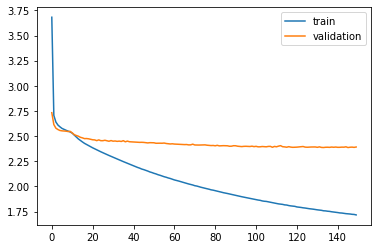

In [77]:
#plot losses by epoch
plt.plot(chinese_history.history['loss'])
plt.plot(chinese_history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()

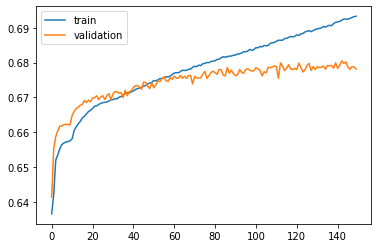

In [78]:
#plot accuracy by epoch
plt.plot(chinese_history.history['accuracy'])
plt.plot(chinese_history.history['val_accuracy'])
plt.legend(['train', 'validation'])
plt.show()

<h3> Chinese LSTM Model Training Observations <h3>

*   The model overall seems to have performed decently. The overall training accuracy was higher than the german model. 
*   The training loss decreased throught the duration of the training but the validation loss plateaued fairly early on.

<h1> Chinese LSTM Model Evaluation

We're using the same metrics as the german LSTM model

In [79]:
#encode and pad test sequences
chinese_test_seq = chinese_tokenizer.texts_to_sequences(chinese_test)

chinese_test_seq_pad = pad_sequences(chinese_test_seq, padding='post')

In [80]:
#loop to iterate through test sequences and append the predicted vs actual sequence
chinese_predicted, chinese_actual = [], []

index = 0
while index < len(chinese_test_seq_pad):
  result = logits_to_sentence(chinese_model.predict(chinese_test_seq_pad[index:index+1])[0], chinese_english_vocab)
  chinese_predicted.append(result)
  chinese_actual.append(chinese_english_test[index])
  index += 1

In [ ]:
#append phrases and evaluation metrics to result dataframe
chinese_result_df = pd.DataFrame(columns=['actual', 'prediction', 'bleu_score', 'F_score'])

for i in range(len(chinese_predicted)):
  comparison = sentence_bleu(chinese_actual[i], chinese_predicted[i], weights=(1, 0, 0, 0))
  chrF_comparison = sentence_chrf(chinese_actual[i], chinese_predicted[i], max_len=1)
  temp_df = pd.DataFrame({'actual':chinese_actual[i], 'prediction':chinese_predicted[i], 'bleu_score':comparison, 'F_score':chrF_comparison}, index=[0])
  chinese_result_df = chinese_result_df.append(temp_df)

In [121]:
chinese_result_df

,actual,prediction,bleu_score,F_score
0,china and the us need to talk,china is is is the to to,0.294118,0.610169
0,asia-pacific leaders must shake off their complacency,the must must to must to to,0.216216,0.350195
0,the politics of young and old,the and of,0.375000,0.456140
0,fifty years ago people spoke often and loudly of a “generation gap”,the the the the the the the to the,0.095238,0.341085
0,start with climate change,consider change change,0.277778,0.613027
...,...,...,...,...
0,in any case let’s wish him luck,and that is to to,0.241379,0.422078
0,zuma rising,portugal in mecca,0.258065,0.615385
0,the stakes for africa are enormous,this is the the the of the the the the,0.177778,0.484330
0,zuma senses the urgency of the situation,the is is is,0.240000,0.363636


In [88]:
print('Mean BLEU-1 score: ', chinese_result_df['bleu_score'].mean())
print('Mean character F-score: ', chinese_result_df['F_score'].mean())

Mean BLEU-1 score:  0.25725371528596364
Mean character F-score:  0.47893936622685834


<h1> GRU Model Architecture <h1>

The GRU model is another common model that we found other researchers have used to tackle this kind of NMT problem. The GRU unit is similar to an RNN/LSTM but has some differences in the gating system. The GRU has a reset gate and update gate. The update gate decides how much of the information to keep while the reset gate decides what to combine with previous memory. GRUs do not have a forget gate or output gate like in LSTM. We found that the tutorial on the TensorFlow website was helpful to understand the architecture (https://www.tensorflow.org/tutorials/text/nmt_with_attention)

This model follows a simple GRU encoder-decoder architecture.

* Layer 1 - Embedding - converts each word integer into an embedding vector
* Layer 2 - GRU - Encoding layer - 64 hidden units that encode the sentences
* Layer 3 - RepeatVector - repeats the output of the GRU layer to maintain dimensions
* Layer 4 - GRU - decoding payer - 64 hidden units that decode the sentences, has return_sequences = True which allows the decoder to understand the hidden state output at each timestep
* Layer 5 - Dense - Classifies the decoded words


<h1> German GRU Model Training <h1>

We used the same hyperparameters as in the LSTM model for these models

In [90]:
#define model architecture
german_GRU_model = Sequential()
german_GRU_model.add(Embedding(10000, 64, input_length=german_encoder_size, mask_zero=True))
german_GRU_model.add(GRU(64, dropout=0.5))
german_GRU_model.add(RepeatVector(german_english_size))
german_GRU_model.add(GRU(64, return_sequences=True))
german_GRU_model.add(TimeDistributed(Dense(10000, activation='softmax')))

adam = Adam(lr=0.001)
german_GRU_model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [91]:
#train model
german_GRU_history = german_GRU_model.fit(german_encoder_sequences_padded, german_english_sequences_padded, epochs=150, batch_size=64, validation_split=0.2)

Epoch 1/150
1125/1125 [==============================] - 46s 38ms/step - loss: 4.7422 - accuracy: 0.4849 - val_loss: 3.7486 - val_accuracy: 0.5100
Epoch 2/150
1125/1125 [==============================] - 41s 36ms/step - loss: 3.7151 - accuracy: 0.5093 - val_loss: 3.6980 - val_accuracy: 0.5106
Epoch 3/150
1125/1125 [==============================] - 41s 36ms/step - loss: 3.6803 - accuracy: 0.5096 - val_loss: 3.6863 - val_accuracy: 0.5107
Epoch 4/150
1125/1125 [==============================] - 40s 36ms/step - loss: 3.6550 - accuracy: 0.5112 - val_loss: 3.6783 - val_accuracy: 0.5113
Epoch 5/150
1125/1125 [==============================] - 40s 36ms/step - loss: 3.6463 - accuracy: 0.5107 - val_loss: 3.6709 - val_accuracy: 0.5112
Epoch 6/150
1125/1125 [==============================] - 40s 36ms/step - loss: 3.6325 - accuracy: 0.5111 - val_loss: 3.6677 - val_accuracy: 0.5111
Epoch 7/150
1125/1125 [==============================] - 40s 36ms/step - loss: 3.6097 - accuracy: 0.5138 - val_loss: 3

<h3> German GRU Model Observations <h3>

This model has performed similar to the LSTM german model that we trained earlier.

Interestingly the GRU models seems to process much faster than the LSTM model. This type of model might be more efficient

In [92]:
# german_GRU_model.save('/german_GRU_model.h5')

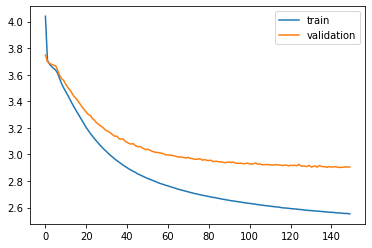

In [93]:
#plot losses by epoch
plt.plot(german_GRU_history.history['loss'])
plt.plot(german_GRU_history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()

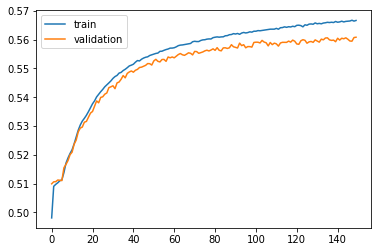

In [94]:
#plot accuracy by epoch
plt.plot(german_GRU_history.history['accuracy'])
plt.plot(german_GRU_history.history['val_accuracy'])
plt.legend(['train', 'validation'])
plt.show()

<h1> German GRU Model Evaluation <h1>

In [95]:
#loop to iterate through predicted sequences and append predicted vs actual phrases
german_GRU_predicted, german_actual = [], []

index = 0
while index < len(german_test_seq_pad):
  result = logits_to_sentence(german_GRU_model.predict(german_test_seq_pad[index:index+1])[0], german_english_vocab)
  german_GRU_predicted.append(result)
  german_actual.append(german_english_test[index])
  index += 1

In [96]:
#define empty result dataframe
german_GRU_result_df = pd.DataFrame(columns=['actual', 'prediction', 'bleu_score', 'F_score'])

In [ ]:
#loop through predicted and actual phrases and score using bleu and f-score
for i in range(len(german_GRU_predicted)):
  bleu_comparison = sentence_bleu(german_actual[i], german_GRU_predicted[i], weights=(1, 0, 0, 0))
  chrF_comparison = sentence_chrf(german_actual[i], german_GRU_predicted[i], max_len=1)
  temp_df = pd.DataFrame({'actual':german_actual[i], 'prediction':german_GRU_predicted[i], 'bleu_score':bleu_comparison, 'F_score':chrF_comparison}, index=[0])
  german_GRU_result_df = german_GRU_result_df.append(temp_df)

In [122]:
german_GRU_result_df

,actual,prediction,bleu_score,F_score
0,a bill to curb sexual and gender-based violence is also in the pipeline,his was dick dick and and and and and,0.173913,0.481752
0,but our work is far from finished,but our is is not,0.300000,0.550459
0,nevertheless the future looks bright,but yet the is is,0.266667,0.423729
0,among the acu’s key areas of work is gender equity,the the the is equality critical,0.272727,0.526316
0,a zero-carbon economy is within reach,a economy is is,0.344828,0.441989
...,...,...,...,...
0,until now populism has been the missing note in african political culture,thus then result has has a a political political political culture,0.191781,0.767123
0,dismissing complaints zuma insists “there’s no cloud around me”,such claims claims and and and and,0.244444,0.506536
0,the stakes for africa are enormous,in africa is is is,0.258065,0.445104
0,zuma senses the urgency of the situation,is the the the urgency,0.342857,0.582278


In [105]:
print('Mean BLEU-1 score: ', german_GRU_result_df['bleu_score'].mean())
print('Mean character F-score: ', german_GRU_result_df['F_score'].mean())

Mean BLEU-1 score:  0.23717072295532915
Mean character F-score:  0.49427236027878524


<h1> Chinese GRU Model Training <h1>

Same hyperparameters as the other models

In [106]:
#define model architecture
chinese_GRU_model = Sequential()
chinese_GRU_model.add(Embedding(10000, 64, input_length=chinese_encoder_size, mask_zero=True))
chinese_GRU_model.add(GRU(64, dropout=0.5))
chinese_GRU_model.add(RepeatVector(chinese_english_size))
chinese_GRU_model.add(GRU(64, return_sequences=True))
chinese_GRU_model.add(TimeDistributed(Dense(10000, activation='softmax')))

In [107]:
#define optimizer, loss function, and metric
adam = Adam(lr=0.001)
chinese_GRU_model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [108]:
#train model
chinese_GRU_history = chinese_GRU_model.fit(chinese_encoder_sequences_padded, chinese_english_sequences_padded, epochs=150, batch_size=64, validation_split=0.2)

Epoch 1/150
351/351 [==============================] - 17s 37ms/step - loss: 5.0603 - accuracy: 0.6178 - val_loss: 2.6700 - val_accuracy: 0.6413
Epoch 2/150
351/351 [==============================] - 12s 34ms/step - loss: 2.6802 - accuracy: 0.6443 - val_loss: 2.6039 - val_accuracy: 0.6580
Epoch 3/150
351/351 [==============================] - 12s 34ms/step - loss: 2.6350 - accuracy: 0.6526 - val_loss: 2.5701 - val_accuracy: 0.6586
Epoch 4/150
351/351 [==============================] - 12s 34ms/step - loss: 2.6004 - accuracy: 0.6530 - val_loss: 2.5620 - val_accuracy: 0.6604
Epoch 5/150
351/351 [==============================] - 12s 34ms/step - loss: 2.5751 - accuracy: 0.6559 - val_loss: 2.5544 - val_accuracy: 0.6621
Epoch 6/150
351/351 [==============================] - 12s 34ms/step - loss: 2.5713 - accuracy: 0.6559 - val_loss: 2.5491 - val_accuracy: 0.6628
Epoch 7/150
351/351 [==============================] - 12s 34ms/step - loss: 2.5572 - accuracy: 0.6568 - val_loss: 2.5361 - val_ac

In [109]:
# chinese_GRU_model.save('/chinese_GRU_model.h5')

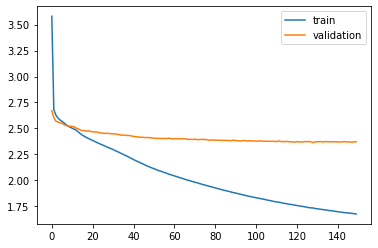

In [110]:
#plot losses by epoch
plt.plot(chinese_GRU_history.history['loss'])
plt.plot(chinese_GRU_history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()

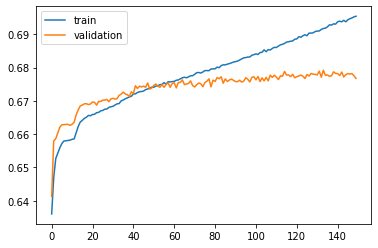

In [111]:
#plot accuracy by epoch
plt.plot(chinese_GRU_history.history['accuracy'])
plt.plot(chinese_GRU_history.history['val_accuracy'])
plt.legend(['train', 'validation'])
plt.show()

<h1> Chinese GRU Model Evaluation <h1>

In [112]:
#iterate through test sequences and append predicted vs actual
chinese_GRU_predicted, chinese_actual = [], []

index = 0
while index < len(chinese_test_seq_pad):
  result = logits_to_sentence(chinese_GRU_model.predict(chinese_test_seq_pad[index:index+1])[0], chinese_english_vocab)
  chinese_GRU_predicted.append(result)
  chinese_actual.append(chinese_english_test[index])
  index += 1

In [ ]:
#score each prediction using evaluation metrics
chinese_GRU_result_df = pd.DataFrame(columns=['actual', 'prediction', 'bleu_score', 'F_score'])

for i in range(len(chinese_GRU_predicted)):
  comparison = sentence_bleu(chinese_actual[i], chinese_GRU_predicted[i], weights=(1, 0, 0, 0))
  chrF_comparison = sentence_chrf(chinese_actual[i], chinese_GRU_predicted[i], max_len=1)
  temp_df = pd.DataFrame({'actual':chinese_actual[i], 'prediction':chinese_GRU_predicted[i], 'bleu_score':comparison, 'F_score':chrF_comparison}, index=[0])
  chinese_GRU_result_df = chinese_GRU_result_df.append(temp_df)

In [116]:
chinese_GRU_result_df

,actual,prediction,bleu_score,F_score
0,china and the us need to talk,china is needs us to,0.375000,0.648464
0,asia-pacific leaders must shake off their complacency,the is must to to to,0.290323,0.334646
0,the politics of young and old,the war of of war cold,0.303030,0.544218
0,fifty years ago people spoke often and loudly of a “generation gap”,the are have the have to the of,0.175000,0.419907
0,start with climate change,the is change change,0.303030,0.620155
...,...,...,...,...
0,in any case let’s wish him luck,so they they he he,0.200000,0.420712
0,zuma rising,obama’s isolation,0.187500,0.534351
0,the stakes for africa are enormous,this is not not the of the the the the the,0.187500,0.564972
0,zuma senses the urgency of the situation,the is is is is,0.222222,0.387597


In [115]:
print('Mean BLEU-1 score: ', chinese_GRU_result_df['bleu_score'].mean())
print('Mean character F-score: ', chinese_GRU_result_df['F_score'].mean())

Mean BLEU-1 score:  0.25150578299463544
Mean character F-score:  0.47360206848708736


<h1> Discussion <h1>

Well, the good news is that these models performed better than the baseline models. The baseline models were only capable of predicting the word "the". So we'll call this a success. The main issue was the extensive padding that was applied. The average sentence length was ranged from 20-30 words. Some of the longest sentences were over 100 words. So the short phrases were being padded with dozens of 0's, causing the gradients to dissipate and thus overfitting. After limiting the max length for the data we saw much better results. However, the translation was still rather poor even after trying every kind of hyperparameter combination. Perhaps it is not a sufficient model architecture or more complex layers are needed to accurately model this data. 